The Phase Kickback swaps the control and the target of the CNOT gate.
When the phase kickback circuit is applied, a "Kickback" is where the eigenvalue added by a gate to a qubit is transferred into a different qubit  with a phase shift via a controlled operation. It is a very important protocol and is used in almost every quantum algorithm.

### Import modules

In [8]:
import qiclib as ql
from qiclib.code import *

from qiclib.packages.qiskit.QiController_backend import QiController_backend
from qiclib.packages.qiskit.QiController_provider import QiController_provider

import matplotlib.pyplot as plt

import numpy as np

from numpy.random import randint

### Call QiController backend Slot3

In [9]:
qic = ql.QiController('slot3-platform')

Platform driver version: v0.1.0 +587 (e87b7dc2, 28.11.2021 20:36) <dirty>
Establishing gRPC connection to slot3-platform:50058...
Standard Qubit-Platform running on ZCU111 board
QiController firmware built 2021-11-28 20:35:34 (rev. 714)
Firmware with 10 digital unit cells detected.


### Define the coupling map

In [10]:
coupling_map = [[0,1]]

### Define the sample

In [11]:
# Define the sample of 3 cells; 2 cells correspond the 2 qubits of the circuit, and the 3rd cell is used
# for coupling q0 and q1
sample = QiCells(3) 

# First cell corresponds to the first qubit of the circuit
sample[0]["rec_pulse"] = 116e-9 # s readout pulse length
sample[0]["rec_length"] = 100e-9 # s recording window size
sample[0]["rec_frequency"] = 60e6 # Hz readout pulse frequency
sample[0]["manip_frequency"] = 80e6 # Hz control pulse frequency
sample[0]["rec_offset"] = 20e-9 # s electrical delay
sample[0]["pi"] = 160e-9 # s Pi pulse duration
sample[0]["T1"] = 2e-6 # s decoherence time
sample[0]["T2"] = 3e-6 # s dephasing time

# Second cell corresponds to the second qubit of the circuit
sample[1]["rec_pulse"] = 116e-9 # s readout pulse length
sample[1]["rec_length"] = 100e-9 # s recording window size
sample[1]["rec_frequency"] = 90e6 # Hz readout pulse frequency
sample[1]["manip_frequency"] = 80e6 # Hz control pulse frequency
sample[1]["rec_offset"] = 20e-9 # s electrical delay
sample[1]["pi"] = 160e-9 # s Pi pulse duration
sample[1]["T1"] = 2e-6 # s decoherence time
sample[1]["T2"] = 3e-6 # s dephasing 

# One additional cell to couple the two qubits q0 and q1, and apply the CNOT gate
sample[2]["gauss_on_pulse_length"] = 24e-9 # s 
sample[2]["rectangular_pulse_length"] = 132e-9 # s 
sample[2]["gauss_off_pulse_length"] = 24e-9 # s 
sample[2]["pulse_frequency"] = 854e6 # Hz

### Amplitude calibration

In [12]:
qic.cell[0].manipulation.amplitude_calibration = (0.5,0.5)
qic.cell[1].manipulation.amplitude_calibration = (0.5,0.5)

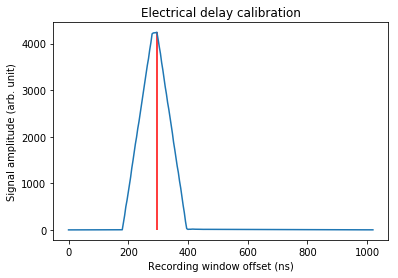

Optimal offset: 296.0 ns
Mirror sideband is 14.5 dB suppressed at recording input


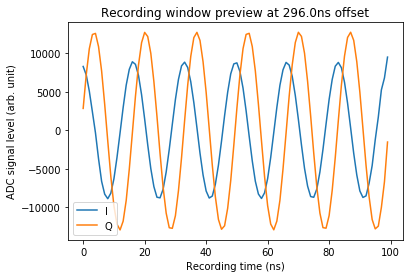

In [13]:
ql.init.calibrate_readout(qic, sample, averages=1000)

In [15]:
with QiJob() as job_test:
    
    q = QiCells(1)
    
    ql.jobs.Readout(q[0], "result")
    
job_test.run(qic, sample, averages=1000, data_collection="iqcloud")

In [17]:
result = job_test.cells[0].data("result")

### State calibration

In [18]:
from qiclib.packages.utility import calculate_stater_config

# Enter the coordinates of the seperation line to each cell of the sample seperately
qic.cell[0].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)
qic.cell[1].recording.state_config = calculate_stater_config(-4560, -1280, -4530, -1270)

### Call QiController provider and define backend

In [19]:
# Call the QiController hardware provider with the specified sample
provider = QiController_provider(qic, sample, coupling_map)

In [20]:
# Create a backend based on the given hardware provider and the sample
backend = QiController_backend(provider)

### Phase kickback circuit

In [21]:
from qiskit import QuantumCircuit

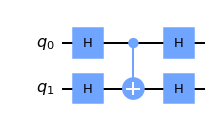

In [22]:
pk_circuit = QuantumCircuit(2)

pk_circuit.h(0)
pk_circuit.h(1)
pk_circuit.cx(0,1)
pk_circuit.h(0)
pk_circuit.h(1)
pk_circuit.draw(output="mpl")

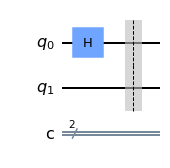

In [23]:
H_circuit = QuantumCircuit(2,2)

H_circuit.h(0)
H_circuit.barrier()
H_circuit.draw(output="mpl")

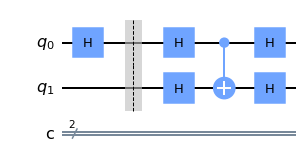

In [24]:
qc = H_circuit.compose(pk_circuit)
qc.draw(output="mpl")

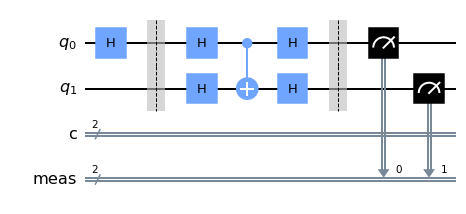

In [25]:
qc.measure_all()
qc.draw(output="mpl")

The expected state is $$\frac{1}{\sqrt{2}} (|00\rangle + |10\rangle)$$

{'000': 0, '001': 0, '010': 0, '011': 10000}


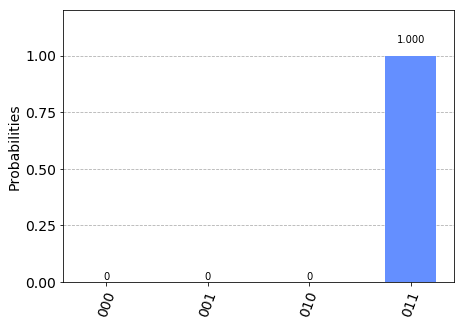

In [26]:
# Create a job by running the circuit on the backend for a number of shots
job = backend.run(qc, 10000)
# Retrieve the measurement results in terms of counts
counts = job.get_counts()
print(counts)

from qiskit.visualization import plot_histogram

# Display the probability distribution of the quantum states
plot_histogram(counts)